In [5]:
import torch
import sys
sys.path.insert(0, '../common')
from torch.autograd import Variable
from data_loading import *
from models import *
from train import *

In [6]:
train_data_path = '../data/openset_classification/train'
train_label_path = train_data_path+'/image_list.txt'
batch_size = 64

In [7]:
data_loader = load_syn2real_data(train_data_path, train_label_path, shuffle = True, batch_size = batch_size)

torch.Size([64, 3, 64, 64])


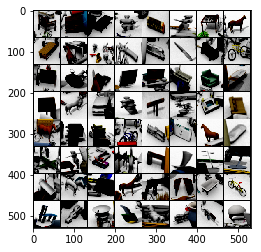

In [8]:
tmp = next(iter(data_loader)) #.dtype(torch.FloatTensor)
print(tmp[0].shape)
utils.save_image(tmp[0])

In [7]:
feature_net = BaseSimpleFeatureNet()
classify_net = ClassifierNet()

In [16]:
feature_net_train(feature_net, classify_net, data_loader, batch_size = batch_size)

/home/bhushan/anaconda3/envs/dl/lib/python3.6/site-packages/ipykernel_launcher.py:34: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch: 0 Total Loss: tensor(38.9491) Last batch Loss: tensor(1.8682)
Epoch: 0 Accuracy: tensor(54)
Epoch: 1 Total Loss: tensor(37.3459) Last batch Loss: tensor(1.9268)
Epoch: 1 Accuracy: tensor(40)
Epoch: 2 Total Loss: tensor(37.1847) Last batch Loss: tensor(1.8663)
Epoch: 2 Accuracy: tensor(40)
Epoch: 3 Total Loss: tensor(36.4657) Last batch Loss: tensor(1.8706)
Epoch: 3 Accuracy: tensor(34)
Epoch: 4 Total Loss: tensor(37.3986) Last batch Loss: tensor(1.6927)
Epoch: 4 Accuracy: tensor(43)


In [ ]:
# import torch
# import torch.nn as nn
# from torch.autograd import Variable
# #output = Variable(torch.rand(1,10))
# #print(output.data.shape)
# output = Variable(torch.Tensor([[-0.3,1,0.4,0.001,0,0,0,0,0,0], [-0.3,1,0.4,0.001,0,0,0,0,0,0], [-0.3,1,0.4,0.001,0,0,0,0,0,0]])).type(dtype)
# print(output.data.shape)
# target = Variable(torch.LongTensor([2, 2, 1]))
# print(target.data.shape)
# criterion = nn.CrossEntropyLoss()
# loss = criterion(output, target)
# print(loss)

In [20]:
test_data_path = '../data/openset_classification/test/'
test_label_file = test_data_path+'/image_list.txt'
batch_size = 64

In [26]:
class Custom_Test_DataLoader(Dataset):
    def __init__(self, root_dir, labels, transform = None):
        self.root_dir = root_dir
        annotations = pd.read_csv(labels, header=None, names=['Class'])
        #with open(labels) as f:
        #    lines = f.read().splitlines()
        self.images = annotations['Class'].tolist()
        annotations['Class'].tolist()
        self.transform = transform

    def __getitem__(self, index):
        image_name = os.path.join(self.root_dir, self.images[index])
        image = Image.open(image_name)
        image = image.convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image

    def __len__(self):
        return len(self.images)

def load_syn2real_data(path, label_file, shuffle = True, batch_size = 64, is_test = False):
    transform = transforms.Compose([
                transforms.Resize((64, 64)),       
                transforms.ToTensor(),
                transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
                ])
    if is_test == False:
        data = Custom_DataLoader(path, label_file, transform)
    else:
        data = Custom_Test_DataLoader(path, label_file, transform)
    data_loader = DataLoader(data, shuffle = shuffle, batch_size = batch_size)
    
    return data_loader 

In [36]:
test_data_loader = load_syn2real_data(test_data_path, test_label_file, shuffle = False, batch_size = 64, is_test = True)


torch.Size([64, 3, 64, 64])


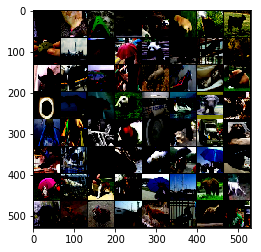

In [37]:
tmp = next(iter(test_data_loader)) #.dtype(torch.FloatTensor)
print(tmp.shape)
utils.save_image(tmp)

In [40]:
dtype = torch.FloatTensor
if torch.cuda.is_available():
    dtype = torch.cuda.FloatTensor

classify_net = ClassifierNet().type(dtype)
gen_net = BaseSimpleFeatureNet().type(dtype)

classify_net.load_state_dict(torch.load('saved_models/c_cpu__net.pkl'))
gen_net.load_state_dict(torch.load('saved_models/g_cpu_net.pkl'))


In [57]:
def test(g_net, c_net, train_data, batch_size = 64, output_file='./test_results.txt'):
    prediction = torch.tensor([])
    for data in train_data:
        s = data
        mini_batch_size = s.shape[0]
        s = var(s).type(dtype)
        output = g_net(s)
        output = c_net(output)
        prediction = torch.cat((prediction, output))
    print(prediction.shape)
    return prediction


In [ ]:
prediction = test(gen_net, classify_net, test_data_loader)